# Tissue comparison for differential expression analysis

In [1]:
import functools
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import binom_test, fisher_exact, linregress

from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation
filterwarnings('ignore', category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [2]:
config = {
    'caudate': '../../../caudate/_m/exons/diffExpr_maleVfemale_full.txt',
    'dlpfc': '../../../dlpfc/_m/exons/diffExpr_maleVfemale_full.txt',
    'hippo': '../../../hippocampus/_m/exons/diffExpr_maleVfemale_full.txt',
}

In [3]:
@functools.lru_cache()
def get_deg(filename):
    dft = pd.read_csv(filename, sep='\t', index_col=0)
    dft['Feature'] = dft.index
    dft['Dir'] = np.sign(dft['t'])
    if 'gene_id' in dft.columns:
        dft['ensemblID'] = dft.gene_id.str.replace('\\..*', '', regex=True)
    return dft[['Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir']]

@functools.lru_cache()
def get_deg_sig(filename, fdr):
    dft = get_deg(filename)
    return dft[(dft['adj.P.Val'] < fdr)]


@functools.lru_cache()
def merge_dataframes(tissue1, tissue2):
    return get_deg(config[tissue1]).merge(get_deg(config[tissue2]), 
                                          on='Feature', suffixes=['_%s' % tissue1, '_%s' % tissue2])


@functools.lru_cache()
def merge_dataframes_sig(tissue1, tissue2):
    fdr1 = 0.05 if tissue1 != 'dlpfc' else 0.05
    fdr2 = 0.05 if tissue2 != 'dlpfc' else 0.05
    return get_deg_sig(config[tissue1], fdr1).merge(get_deg_sig(config[tissue2], fdr2), 
                                                    on='Feature', suffixes=['_%s' % tissue1, '_%s' % tissue2])

In [4]:
def enrichment_binom(tissue1, tissue2, merge_fnc):
    df = merge_fnc(tissue1, tissue2)
    df['agree'] = df['Dir_%s' % tissue1] * df['Dir_%s' % tissue2]
    dft = df.groupby('agree').size().reset_index()
    print(dft)
    return binom_test(dft[0].iloc[1], dft[0].sum()) if dft.shape[0] != 1 else print("All directions agree!")


def cal_fishers(tissue1, tissue2):
    df = merge_dataframes(tissue1, tissue2)
    fdr1 = 0.05 if tissue1 != 'dlpfc' else 0.05
    fdr2 = 0.05 if tissue2 != 'dlpfc' else 0.05
    table = [[np.sum((df['adj.P.Val_%s' % tissue1]<fdr1) & 
                     ((df['adj.P.Val_%s' % tissue2]<fdr2))),
              np.sum((df['adj.P.Val_%s' % tissue1]<fdr1) & 
                     ((df['adj.P.Val_%s' % tissue2]>=fdr2)))],
             [np.sum((df['adj.P.Val_%s' % tissue1]>=fdr1) & 
                     ((df['adj.P.Val_%s' % tissue2]<fdr2))),
              np.sum((df['adj.P.Val_%s' % tissue1]>=fdr1) & 
                     ((df['adj.P.Val_%s' % tissue2]>=fdr2)))]]
    print(table)
    return fisher_exact(table)


def calculate_corr(xx, yy):
    '''This calculates R^2 correlation via linear regression:
         - used to calculate relationship between 2 arrays 
         - the arrays are principal components 1 or 2 (PC1, PC2) AND gender
         - calculated on a scale of 0 to 1 (with 0 being no correlation)
        Inputs: 
          x: array of Gender (converted to binary output)
          y: array of PC
        Outputs: 
          1. r2
          2. p-value, two-sided test 
            - whose null hypothesis is that two sets of data are uncorrelated
          3. slope (beta): directory of correlations
    '''
    slope, intercept, r_value, p_value, std_err = linregress(xx, yy)
    return r_value, p_value

    
def corr_annotation(tissue1, tissue2, merge_fnc):
    dft = merge_fnc(tissue1, tissue2)
    xx = dft['t_%s' % tissue1]
    yy = dft['t_%s' % tissue2]
    r_value1, p_value1 = calculate_corr(xx, yy)
    return 'R2: %.2f\nP-value: %.2e' % (r_value1**2, p_value1)


def tissue_annotation(tissue):
    return {'dlpfc': 'DLPFC', 'hippo': 'Hippocampus', 'caudate': 'Caudate'}[tissue]

In [5]:
def plot_corr_impl(tissue1, tissue2, merge_fnc):
    dft = merge_fnc(tissue1, tissue2)
    title = '\n'.join([corr_annotation(tissue1, tissue2, merge_fnc)])
    xlab = 'T-statistic (%s)' % tissue_annotation(tissue1)
    ylab = 'T-statistic (%s)' % tissue_annotation(tissue2)
    pp = ggplot(dft, aes(x='t_%s'%tissue1, y='t_%s' % tissue2))\
    + geom_point(alpha=0.75, size=3)\
    + theme_matplotlib()\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=20, face='bold'), 
            plot_title=element_text(size=22))
    pp += labs(x=xlab, y=ylab, title=title)
    return pp


def plot_corr(tissue1, tissue2, merge_fnc):
    return plot_corr_impl(tissue1, tissue2, merge_fnc)


def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)

## Sample summary

In [6]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/merged/_m/merged_phenotypes.csv'
pheno = pd.read_csv(pheno_file, index_col=0)
pheno = pheno[(pheno['Age'] > 17) & (pheno['Dx'].isin(['Schizo', 'Control']))]
pheno.head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
R12864,Br1303,R12864,Caudate,9.6,42.98,F,AA,Schizo
R12865,Br1320,R12865,Caudate,9.5,53.12,M,AA,Schizo


In [7]:
pheno.groupby(['Region']).size()

Region
Caudate    394
DLPFC      379
HIPPO      376
dtype: int64

In [8]:
pheno.groupby(['Region', 'Sex']).size()

Region   Sex
Caudate  F      121
         M      273
DLPFC    F      117
         M      262
HIPPO    F      121
         M      255
dtype: int64

## BrainSeq Tissue Comparison

In [9]:
caudate = get_deg(config['caudate'])
caudate.groupby('Dir').size()

Dir
-1.0    161483
 1.0    200424
dtype: int64

In [10]:
caudate[(caudate['adj.P.Val'] < 0.05)].shape

(1479, 6)

In [11]:
dlpfc = get_deg(config['dlpfc'])
dlpfc.groupby('Dir').size()

Dir
-1.0    159909
 1.0    180617
dtype: int64

In [12]:
dlpfc[(dlpfc['adj.P.Val'] < 0.05)].shape

(3566, 6)

In [13]:
hippo = get_deg(config['hippo'])
hippo.groupby('Dir').size()

Dir
-1.0    165547
 1.0    172915
dtype: int64

In [14]:
hippo[(hippo['adj.P.Val'] < 0.05)].shape

(952, 6)

### Enrichment of DEG

In [15]:
cal_fishers('caudate', 'dlpfc')

[[926, 453], [2528, 327965]]


(265.1937068628273, 0.0)

In [16]:
cal_fishers('caudate', 'hippo')

[[843, 528], [87, 330382]]


(6063.044801462905, 0.0)

In [17]:
cal_fishers('dlpfc', 'hippo')

[[839, 2612], [98, 325383]]


(1066.491925024221, 0.0)

### Correlation

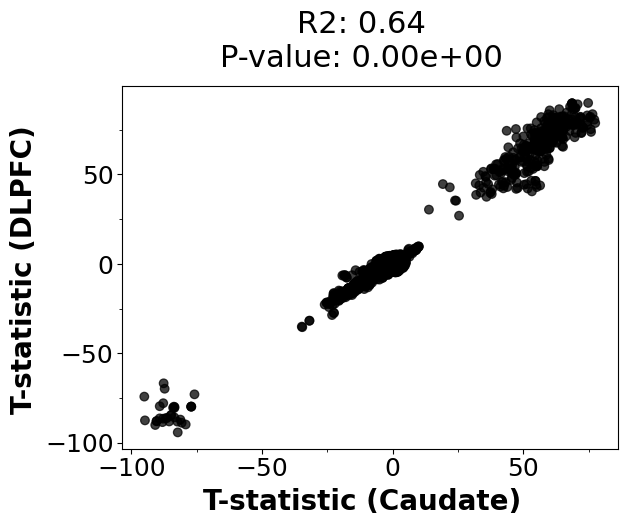

<ggplot: (8758849247720)>

In [18]:
pp = plot_corr('caudate', 'dlpfc', merge_dataframes)
pp

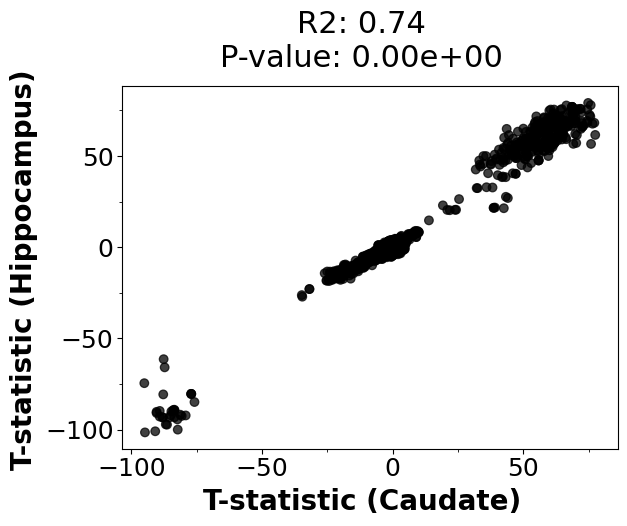

<ggplot: (8758843068088)>

In [19]:
qq = plot_corr('caudate', 'hippo', merge_dataframes)
qq

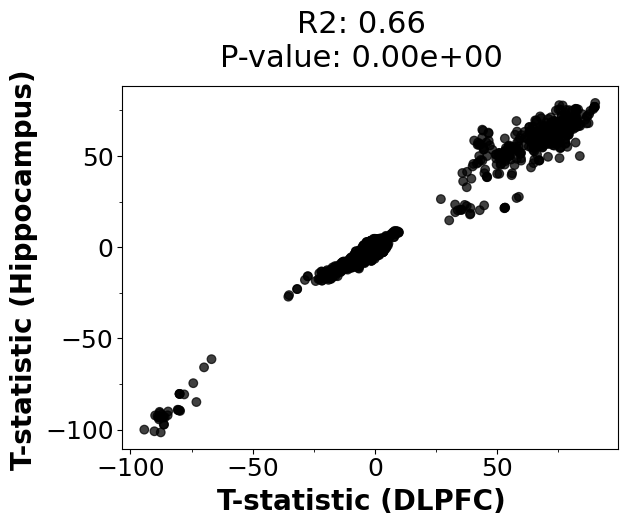

<ggplot: (8758834708980)>

In [20]:
ww = plot_corr('dlpfc', 'hippo', merge_dataframes)
ww

### Significant correlation, FDR < 0.05

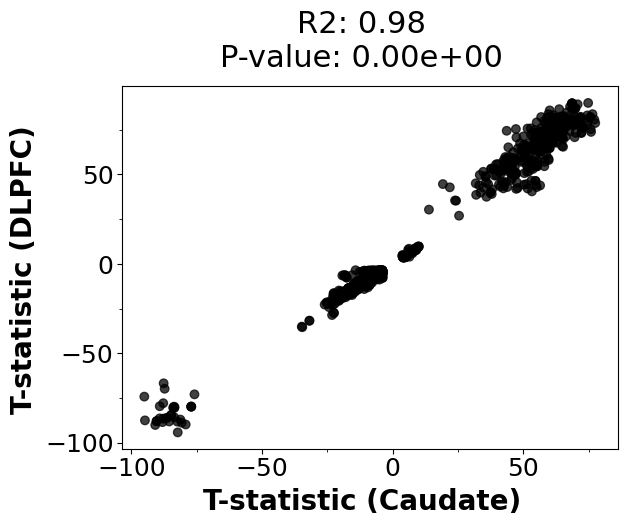

<ggplot: (8758844820517)>

In [21]:
pp = plot_corr('caudate', 'dlpfc', merge_dataframes_sig)
pp

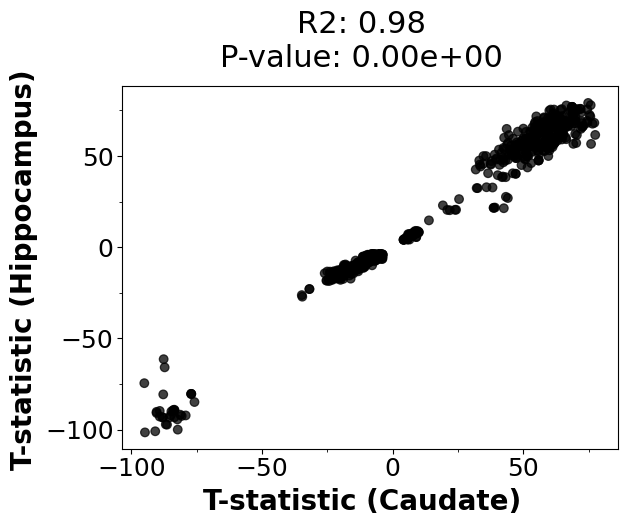

<ggplot: (8758846483188)>

In [22]:
qq = plot_corr('caudate', 'hippo', merge_dataframes_sig)
qq

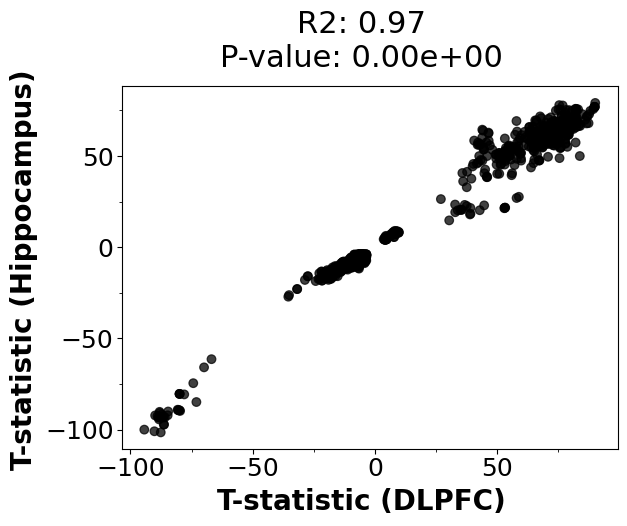

<ggplot: (8758848693074)>

In [23]:
ww = plot_corr('dlpfc', 'hippo', merge_dataframes_sig)
ww

### Directionality test

#### All genes

In [24]:
enrichment_binom('caudate', 'dlpfc', merge_dataframes)

   agree       0
0   -1.0  138330
1    1.0  193542


2e-323

In [25]:
enrichment_binom('caudate', 'hippo', merge_dataframes)

   agree       0
0   -1.0  127676
1    1.0  204164


2e-323

In [26]:
enrichment_binom('dlpfc', 'hippo', merge_dataframes)

   agree       0
0   -1.0  139036
1    1.0  189896


2e-323

#### Significant DEG (FDR < 0.05)

In [27]:
enrichment_binom('caudate', 'dlpfc', merge_dataframes_sig)

   agree    0
0    1.0  926
All directions agree!


In [28]:
enrichment_binom('caudate', 'hippo', merge_dataframes_sig)

   agree    0
0    1.0  843
All directions agree!


In [29]:
enrichment_binom('dlpfc', 'hippo', merge_dataframes_sig)

   agree    0
0    1.0  839
All directions agree!
